In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 神经网络回归案例

二手车价格预测，数据包含1435 个观测，8 个变量，其中 Price 为目标变
量，其余为特征，包括 Age（按月车龄）、KM（行驶里程）、Weight（车重）、HP（马力）、CC（发动机尺寸）、MetColor（是否金属色）、Doors（车门数）。
## 1. 创建任务
读取数据，将 MetColor 转化为因子型，将 Price 单位转化为万美元

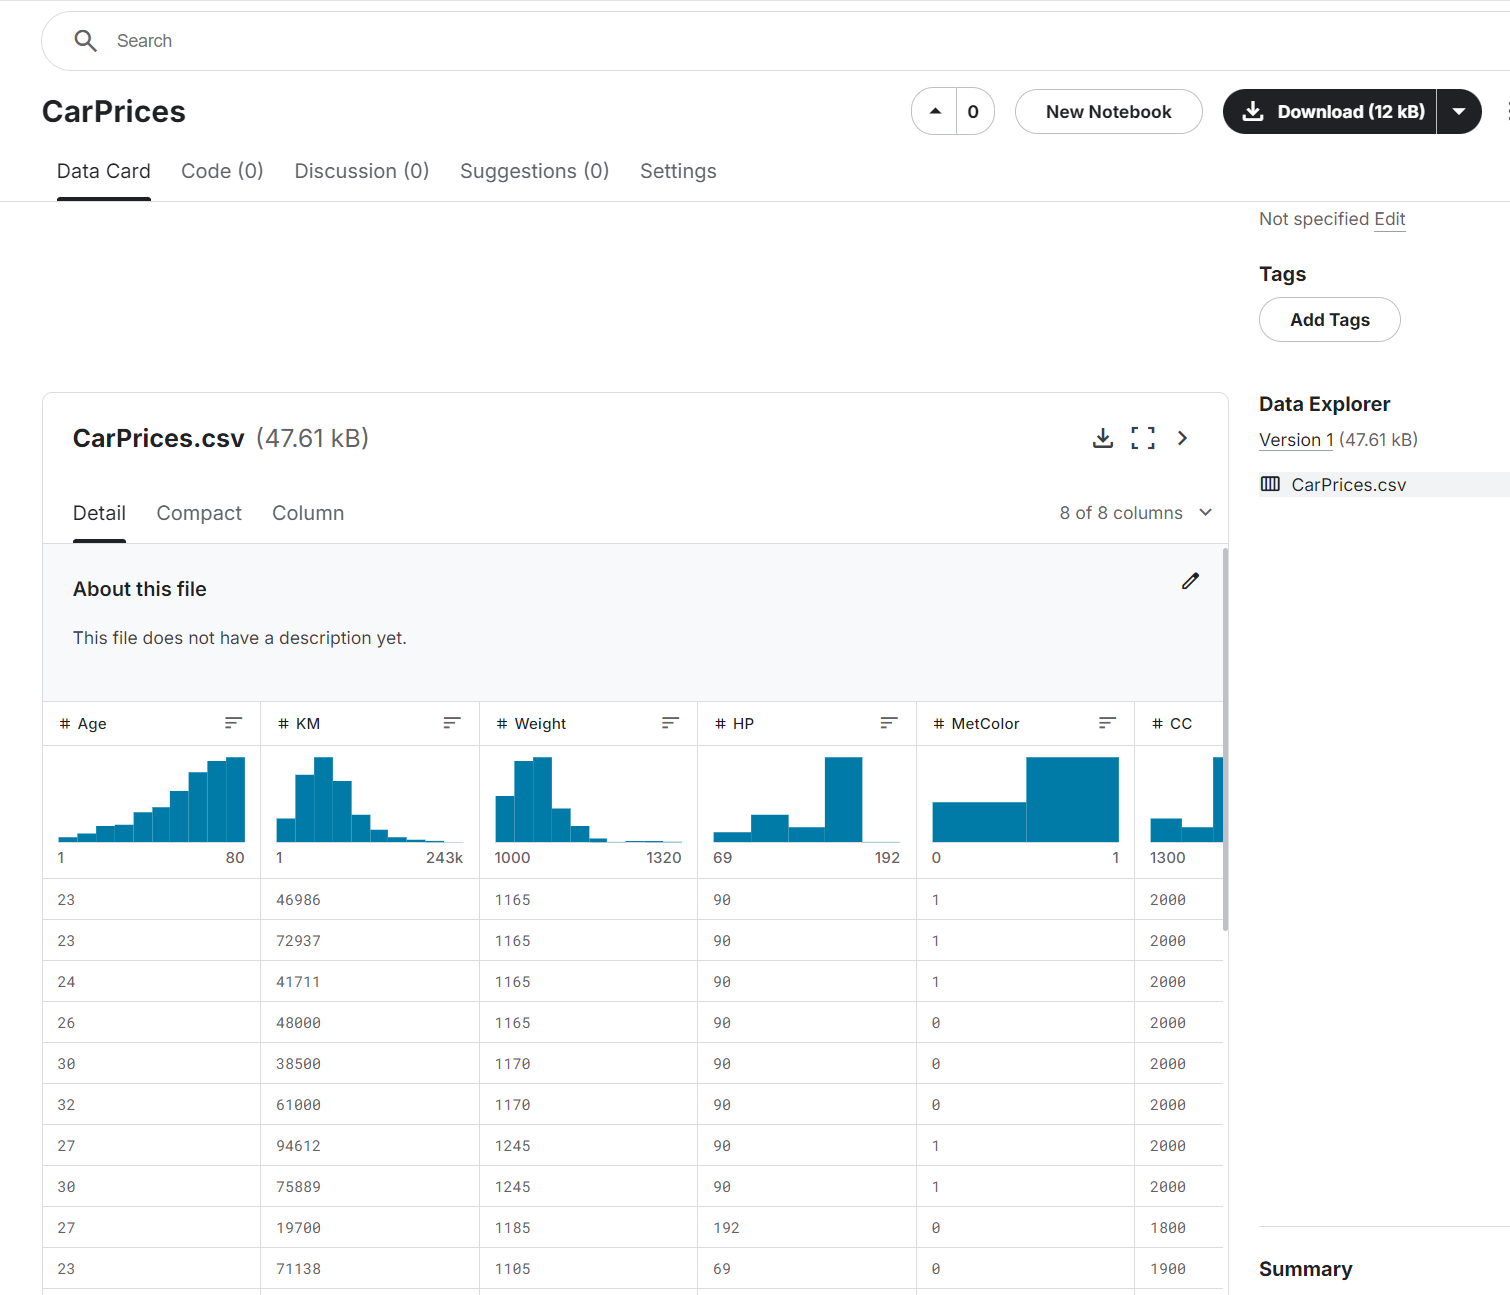

In [3]:
library(tidyverse)
 library(mlr3verse)
 dat = read_csv("/kaggle/input/carprices/CarPrices.csv") %>%
 mutate(MetColor = as.factor(MetColor),
 Price = Price / 10000)



Rows: 1435 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): Age, KM, Weight, HP, MetColor, CC, Doors, Price

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
glimpse(dat)

Rows: 1,435
Columns: 8
$ Age      <dbl> 23, 23, 24, 26, 30, 32, 27, 30, 27, 23, 25, 22, 25, 31, 32, 2…
$ KM       <dbl> 46986, 72937, 41711, 48000, 38500, 61000, 94612, 75889, 19700…
$ Weight   <dbl> 1165, 1165, 1165, 1165, 1170, 1170, 1245, 1245, 1185, 1105, 1…
$ HP       <dbl> 90, 90, 90, 90, 90, 90, 90, 90, 192, 69, 192, 192, 192, 192, …
$ MetColor <fct> 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1…
$ CC       <dbl> 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1800, 1900, 1…
$ Doors    <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ Price    <dbl> 1.350, 1.375, 1.395, 1.495, 1.375, 1.295, 1.690, 1.860, 2.150…


数据预处理

特征分正向、负向归一化到[−1,1]

In [5]:

 rescale =function(x,type = "+", a= 0, b= 1){
 rng= range(x,na.rm =TRUE)
 switch (type,
 "+"=(b-a) *(x-rng[1]) /(rng[2]-rng[1]) + a,
 "-"=(b-a) *(rng[2]-x) /(rng[2]-rng[1]) + a)
 }
 dat =dat%>%
 mutate(across(1:2,rescale, type= "-", a=-1),
 across(c(3:4, 6:7),rescale, a=-1))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(1:2, rescale, type = "-", a = -1)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


In [6]:
task = as_task_regr(dat, target = "Price")
 task

<TaskRegr:dat> (1435 x 8)
* Target: Price
* Properties: -
* Features (7):
  - dbl (6): Age, CC, Doors, HP, KM, Weight
  - fct (1): MetColor

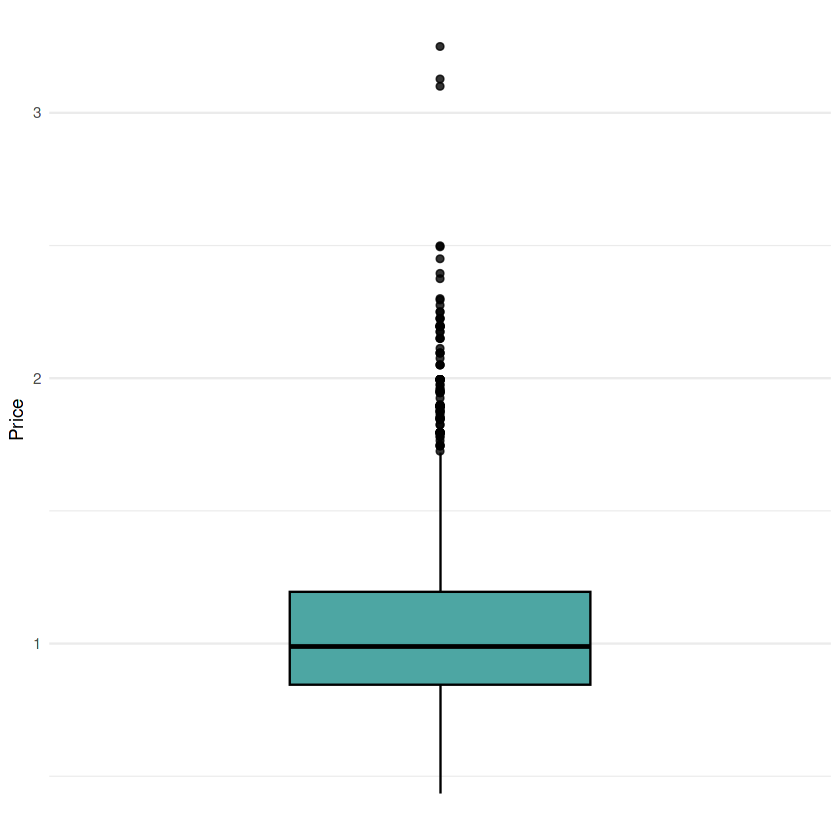

In [7]:
autoplot(task)

可见，目标变量有右偏！

## 2. 划分训练集和测试集

做留出重抽样，80% 作为训练集，其余 20% 作为测试集。为了保持训练集、
测试集的因变量数据具有相似的分布，采用分层抽样方法：
• 用 partition() 函数对任务做划分，默认按因变量分层，返回列表
包含训练集索引和测试集索引。


In [8]:
set.seed(123)
 split = partition(task, ratio = 0.8)

## 3. 选择学习器
learner = lrn("regr.nnet", trace = FALSE, # 需要 nnet 包
size = to_tune(p_int(2, 30)))
 learner

In [9]:
learner = lrn("regr.nnet", trace = FALSE, # 需要 nnet 包
size = to_tune(p_int(2, 30)))
 learner

<LearnerRegrNnet:regr.nnet>: Single Layer Neural Network
* Model: -
* Parameters: size=<ObjectTuneToken>, trace=FALSE
* Packages: mlr3, mlr3learners, nnet
* Predict Types:  [response]
* Feature Types: integer, numeric, factor, ordered
* Properties: weights

目标变换
接一个目标对数变换，变成图学习器


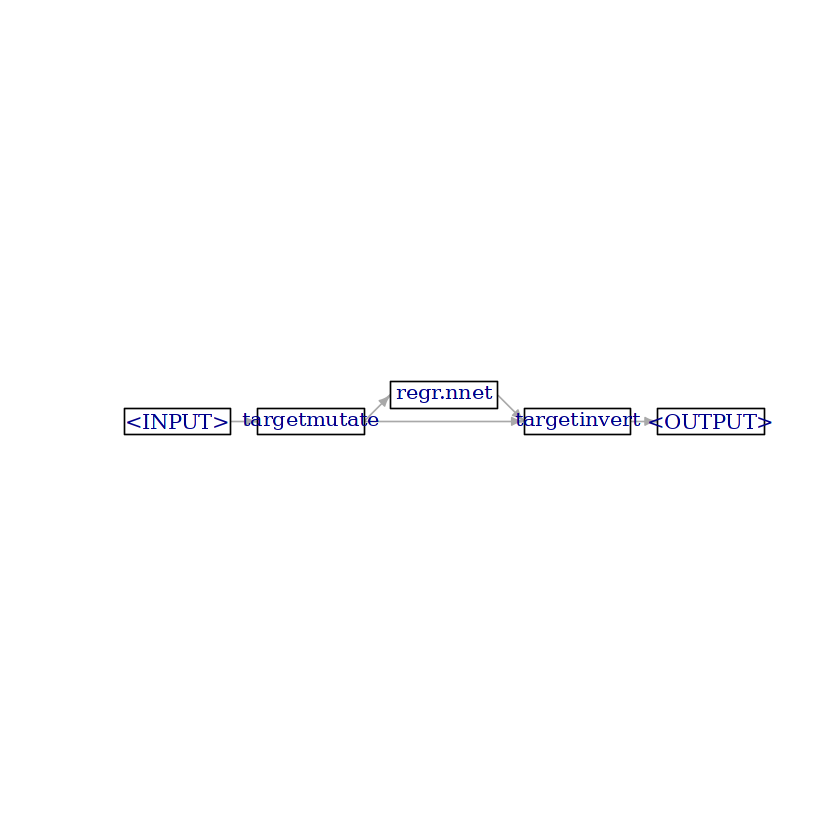

In [10]:
gr_log = ppl("targettrafo", graph = learner,
 targetmutate.trafo = \(x) log(x),
 targetmutate.inverter = \(x)
 list(response = exp(x$response)))
 gr_log$plot(horizontal = TRUE)

## 4.超参数调参
对模型中超参数：隐层神经元个数size做调参，已创建为带该调参的学习
器。
使用自动调参器，需要设置学习器、重抽样方法、模型评估指标、终止条件、
搜索方法


In [11]:
at = auto_tuner(
 tuner=tnr("random_search"),
 learner= gr_log,
 resampling= rsmp("cv", folds= 3),
 measure= msr("regr.rsq"),
 term_evals= 20)

在训练集上启动调参过程

 

In [12]:
set.seed(12)
 at$train(task, row_ids= split$train)

INFO  [11:01:44.560] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=20, k=0]'
INFO  [11:01:44.646] [bbotk] Evaluating 1 configuration(s)
INFO  [11:01:44.672] [mlr3] Running benchmark with 3 resampling iterations
INFO  [11:01:44.749] [mlr3] Applying learner 'targetmutate.regr.nnet.targetinvert' on task 'dat' (iter 1/3)
INFO  [11:01:45.088] [mlr3] Applying learner 'targetmutate.regr.nnet.targetinvert' on task 'dat' (iter 2/3)
INFO  [11:01:45.409] [mlr3] Applying learner 'targetmutate.regr.nnet.targetinvert' on task 'dat' (iter 3/3)
INFO  [11:01:45.817] [mlr3] Finished benchmark
INFO  [11:01:45.898] [bbotk] Result of batch 1:
INFO  [11:01:45.905] [bbotk]  regr.nnet.size regr.rsq warnings errors runtime_learners
INFO  [11:01:45.905] [bbotk]              11 0.878705        0      0            0.899
INFO  [11:01:45.905] [bbotk]                                 uhash
INFO  [11:01:45.905] [bbotk]  0ee32eee-ba0f-4bf3-a875-a9224661e

•查看最优超参数


In [13]:
at$tuning_result #调参结果

regr.nnet.size,learner_param_vals,x_domain,regr.rsq
<int>,<list>,<list>,<dbl>
5,"FALSE, function (x) , log(x), function (x) , list(response = exp(x$response)), 5",5,0.8957554


## 5. 训练模型
自动调参器已经使用超参数调参得到最优超参数在整个训练集上重新训练，取
出该模型结果，可以跟直接用 nnet::nnet() 训练模型得到的模型结果一
样使用。


In [14]:
nnet = at$learner$model

## 6. 模型预测及评估


In [15]:
pred = at$predict(task, row_ids = split$test)
 pred

<PredictionRegr> for 288 observations:
    row_ids truth  response
          1 1.350 1.4720455
         31 1.295 1.5858323
        186 0.695 0.6740769
---                        
        357 1.499 1.4344395
        110 3.250 2.4358614
        141 2.395 2.3423728

• 计算均方根误差与R方


In [16]:
pred$score(msrs(c("regr.rmse", "regr.rsq")))

regr.rmse  regr.rsq 
0.1312707 0.8768096

## 7.预测新数据

注意，真正的新数据，需要做同样的归一化等预处理。

In [17]:
newdata =dat[1:5,-8]
 at$predict_newdata(newdata)
 #><PredictionRegr> for 5observations:
 #> row_ids truth response
 #> 1 NA 1.47
 #> 2 NA 1.45
 #> 3 NA 1.46
 #> 4 NA 1.48
 #> 5 NA 1.47

<PredictionRegr> for 5 observations:
 row_ids truth response
       1    NA 1.472045
       2    NA 1.445318
       3    NA 1.463920
       4    NA 1.481412
       5    NA 1.465806

 ## mlr3torch
 mlr3torch 是一个基于 torch 构建的 mlr3 生态系统的深度学习框架。
它允许在几行代码中轻松构建、训练和评估深度学习模型，而无需担心低级细
节。可以使用现成的学习器，也可以通过 PipeOpTorch 管道操作搭建
Graph 的方式自定义架构。
 


In [18]:
library(mlr3torch)
 task =tsk("sonar")
 task
 #><TaskClassif:sona

ERROR: Error in library(mlr3torch): there is no package called ‘mlr3torch’


In [7]:
#install.packages("mlr3torch")

#install.packages("mlr3torch",repos="https://mirrors.sustech.edu.cn/CRAN/web/packages/mlr3torch/index.html")
#install.packages("mlr3torch",repos="https://mirrors.sustech.edu.cn/CRAN/bin/macosx/big-sur-arm64/contrib/4.4")
install.packages("mlr3torch",repos="https://cran.r-project.org/bin/windows/contrib/4.4")
 


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository https://cran.r-project.org/bin/windows/contrib/4.4/src/contrib:
  cannot open URL 'https://cran.r-project.org/bin/windows/contrib/4.4/src/contrib/PACKAGES'”
Warning message:
“package ‘mlr3torch’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


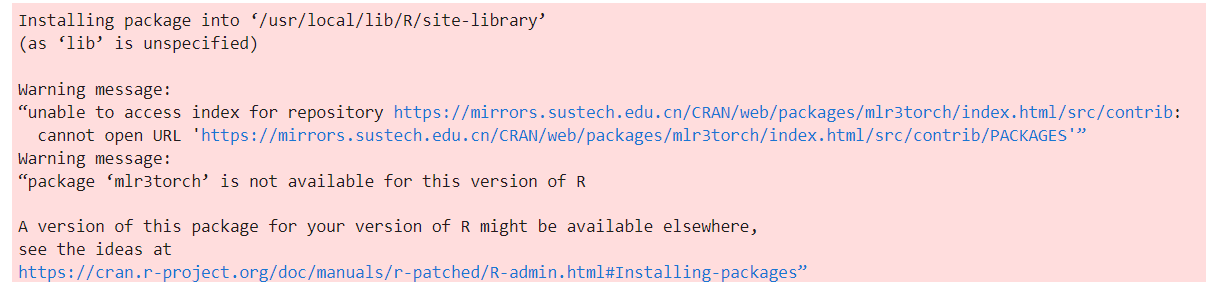


https://mirrors.sustech.edu.cn/CRAN/bin/macosx/big-sur-arm64/contrib/4.4/mlr3torch_0.1.0.tgz


https://cran.r-project.org/bin/windows/contrib/4.4/mlr3torch_0.1.0.zip

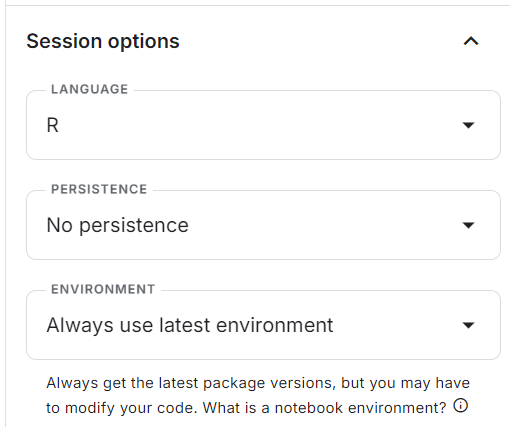

用R最新的版本

在Kaggle中切换到高版本的R，你需要在你的Kaggle笔记本的设置中指定R的版本。以下是如何在Kaggle中切换R版本的步骤：

打开你的Kaggle笔记本。

在笔记本界面的右上角，点击齿轮图标打开“Notebook Settings”。

在“Notebook Settings”中，找到“Language & Environment”部分。

在“Runtime”下拉菜单中，选择你想要使用的R版本。Kaggle通常提供几个常用的R版本选项，如R3.5.x、R3.6.x、R4.0.x等。

如果你需要的版本不在列表中，可以选择“Custom”，然后在“Setup Code”框中输入特定的安装命令来安装高版本的R。

点击“Save”保存设置。

In [1]:
version


               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          4.0                         
year           2024                        
month          04                          
day            24                          
svn rev        86474                       
language       R                           
version.string R version 4.4.0 (2024-04-24)
nickname       Puppy Cup                   

In [8]:
library(mlr3torch)
 task =tsk("sonar")
 task
 #><TaskClassif:sona

ERROR: Error in library(mlr3torch): there is no package called ‘mlr3torch’


set.seed(123)

 split = partition(task, ratio=0.8)
 
 
 
mlp = lrn("classif.mlp",

 # 网络参数
 
activation = nn_relu,

 neurons = c(50, 50),
 
 # 训练参数
 
batch_size = 8,

 epochs = 500,
 
 device = "cuda",
 
 # "cpu"
 
 # 验证集比例
 
validate = 0.2,

In [9]:
set.seed(123)
 split = partition(task, ratio=0.8)
 51
mlp = lrn("classif.mlp",
 # 网络参数
activation = nn_relu,
 neurons = c(50, 50),
 # 训练参数
batch_size = 8,
 epochs = 500,
 device = "cuda",
 # "cpu"
 # 验证集比例
validate = 0.2,

ERROR: Error in parse(text = x, srcfile = src): <text>:15:0: unexpected end of input
13:  # 验证集比例
14: validate = 0.2,
   ^


In [10]:
# 优化器, 损失, 回调
optimizer = t_opt("adam", lr = 0.001),
 loss = t_loss("cross_entropy"),
 callbacks = t_clbk("history"), # 让学习器保存历史记录
# 跟踪度量
measures_valid = msr("classif.ce"),
 measures_train = msr("classif.ce"),
 # 预测类型 (logloss 需要)
 predict_type = "prob")

ERROR: Error in parse(text = x, srcfile = src): <text>:2:38: unexpected ','
1: # 优化器, 损失, 回调
2: optimizer = t_opt("adam", lr = 0.001),
                                        ^


In [ ]:
mlp

In [ ]:
mlp$train(task, row_ids= split$train)
 lrn_curves= mlp$model$callbacks$history %>%
 bind_rows(.id= "Type")
 lrn_curves

In [ ]:
lrn_curves %>%
 slice(seq(1, 1000, 50)) %>%
 ggplot(aes(epoch, classif.ce, color = Type)) +
 geom_line() +
 theme_minimal()

In [ ]:
pred =mlp$predict(task, row_ids= split$test)
 pred

In [ ]:
pred$confusion
 #>
 truth
 #> response M R
 #>
 M 20 2
 #>
 R 2 17
 pred$score(msr("classif.acc"))